In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, csv
from IPython.display import display
from wordcloud import WordCloud
# reload(sys)  
# sys.setdefaultencoding('utf8')

%matplotlib inline

## load data into dataframe:

In [2]:
# load data into dataframe
data =  pd.read_csv('quora_duplicate_questions.tsv',sep='\t', header=0)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Class labels distrubtion:

Total number of question pairs for data = 404290
Label 0 (not a same question) is 63.08 % of the data
Label 1 (same question) is 36.92 % of the data


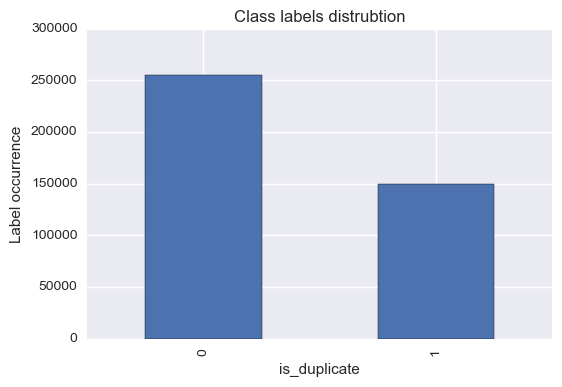

In [3]:
labels_dist = data.groupby(['is_duplicate'])['is_duplicate'].count()
total_rows = labels_dist.sum()
label_prob = labels_dist/ total_rows
print('Total number of question pairs for data = ' + str(total_rows))
print('Label 0 (not a same question) is {} % of the data'.format(str(round(label_prob[0]*100,2))) )
print('Label 1 (same question) is {} % of the data'.format(str(round(label_prob[1]*100,2))))
plt.ylabel('Label occurrence')
ax =labels_dist.plot(kind='bar', title='Class labels distrubtion')

## Question level:

#### In this part, the number of occurrence for each equstion will be examine and check if there are some relation with the target label. 

#### The "qid1" and "qid2" should be unique per each question, so we can use them in our analysis. However, I will not go with this because there are some questions that repeated with different ids such as the following:

In [4]:
q1s = pd.DataFrame()
q2s = pd.DataFrame()
q1s[['question','qid','is_duplicate']] = data[['question1','qid1','is_duplicate']]
q2s[['question','qid','is_duplicate']] = data[['question2','qid2','is_duplicate']]
qs = pd.concat([q1s, q2s], ignore_index=True)

In [5]:
v = qs.groupby(['question','qid'], as_index=False).count()
vv = v.groupby('question').count()
m = vv[vv['is_duplicate'] > 1].index.values
print('Number of questions with duplicate qids = {}'.format(len(m)))
v[v['question'].isin(m)][['question','qid']].head(n=14)

Number of questions with duplicate qids = 528


,question,qid
641,?,25026
642,?,39204
643,?,84068
644,?,161071
645,?,171925
646,?,214814
647,?,312495
648,?,391451
649,?,535899
653,? to be deleted,42085


#### Two things that we can notice from the above table. First, there are some questions that have multiple qids. Second, there are some questions that may just one charachter like question mark.

Total number of questions is 808580
Total number of unique questions in the data: 537361
Number of quesitons occured exactly once is 425489 with 79.18 % of the unique questions


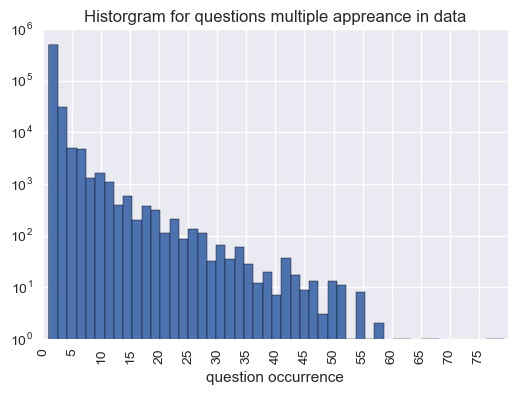

In [6]:
print('Total number of questions is {}'.format(len(qs)))
plt.title('Historgram for questions multiple appreance in data')
plt.xlabel('question occurrence')
qids_grouped = qs.groupby('question')['question'].count()
ax = qids_grouped.hist(bins=100)
plt.xticks(np.arange(0,80,5))
plt.xlim(0,80)
plt.xticks(rotation='vertical')
plt.yscale('log')
mqids = len(qids_grouped.values[qids_grouped.values == 1])
len_unq = len(qids_grouped)
print('Total number of unique questions in the data: {}'.format(len_unq))
print('Number of quesitons occured exactly once is {} with {} % of the unique questions'.format(mqids,round(100.0*mqids/(len_unq),2)))

### We have 111872 occured more than once. So, let's take a deeper look on the mean of their labels:

Total number of unique questions 537361
Number of questions that repeated more than once 111872 with 20.82%
Number of questions that has Mean of is_duplicate > 0.5 = 43819 with 8.15448087971%
Number of questions that has Mean of is_duplicate == 0.5 = 12401 with 2.30775958806%
Number of questions that has Mean of is_duplicate < 0.5 = 55652 with 10.3565387142%


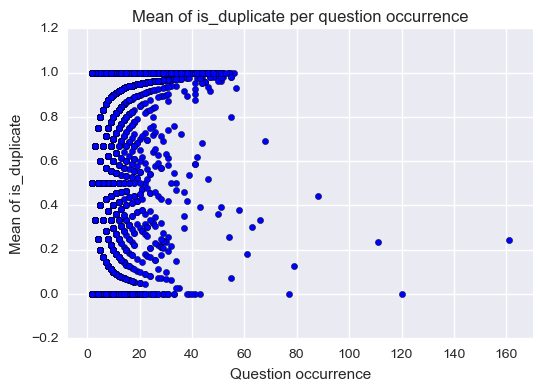

In [7]:
# group on the question. Count each equstion (occurence) and calculate the mean of its duplicate.
v = qs.groupby('question')[['is_duplicate']].agg([np.mean,'count'])
print('Total number of unique questions {}'.format(len(v)))
more_than_once = len(v[v['is_duplicate']['count'] > 1])
print('Number of questions that repeated more than once {} with {}%'.format(more_than_once, round(more_than_once*100.0/len(v),2)))
v1 = v[v['is_duplicate']['count'] > 1]

plt.title('Mean of is_duplicate per question occurrence')
plt.xlabel('Question occurrence')
plt.ylabel('Mean of is_duplicate')
plt.xticks(np.arange(0,200,20))
ax = plt.scatter(v1['is_duplicate']['count'].tolist(),v1['is_duplicate']['mean'].tolist())
print('Number of questions that has Mean of is_duplicate > 0.5 = {} with {}%'.format(len(v1[v1['is_duplicate']['mean'] > 0.5]),len(v1[v1['is_duplicate']['mean'] > 0.5])*100.0/len(v)))
print('Number of questions that has Mean of is_duplicate == 0.5 = {} with {}%'.format(len(v1[v1['is_duplicate']['mean'] == 0.5]),len(v1[v1['is_duplicate']['mean'] == 0.5])*100.0/len(v)))
print('Number of questions that has Mean of is_duplicate < 0.5 = {} with {}%'.format(len(v1[v1['is_duplicate']['mean'] < 0.5]),len(v1[v1['is_duplicate']['mean'] < 0.5])*100.0/len(v)))

#### Conclusion: number of occurrence of the question may not give a good indication for predicting the label which around 79.78% of questions are repeated once and these questions that have occured more than once are almost equally distributed.

## Prepare data:

In [8]:
def quickClean(text):
    text = str(text)
    text = text.replace(',',' ')
    while('_' in text):
        text = text.replace('_',' ')
    text = text.replace('?',' ')
    while('.' in text):
        text = text.replace('.',' ')
    text = text.replace('\'m',' am')
    text = text.replace('what\'s','what is')
    text = text.replace('\'ve',' have')
    return text
#===============================================================
def parseDiffQuestions(row):
    words1 = set(row['quest1Split'])
    words2 = set(row['quest2Split'])
    row['unique']  = list(words1.intersection(words2))
    row['unq1'] = list(words1.difference(words2))
    row['unq2'] = list(words2.difference(words1))
    return row

In [9]:
data['question1'] = data['question1'].map(lambda x: str(x))
data['question2'] = data['question2'].map(lambda x: str(x))
data['question11'] = data['question1'].map(quickClean)
data['question22'] = data['question2'].map(quickClean)

data['quest1Split'] = data['question11'].map(lambda x: x.split())
data['quest2Split'] = data['question22'].map(lambda x: x.split())
data['ques1_word_len'] = data['quest1Split'].map(len)
data['ques2_word_len'] = data['quest2Split'].map(len)
data['ques1_char_len'] = data['question11'].map(len) - data['ques1_word_len'] + 1
data['ques2_char_len'] = data['question22'].map(len) - data['ques2_word_len'] + 1
data['words_count_diff'] = data['ques1_word_len'] - data['ques2_word_len']
data['abs_words_count_diff'] = abs(data['ques1_word_len'] - data['ques2_word_len'])

In [10]:
data = data.apply(parseDiffQuestions,axis=1)
data['intersect_word_len'] = data['unique'].map(len)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question11,question22,quest1Split,quest2Split,ques1_word_len,ques2_word_len,ques1_char_len,ques2_char_len,words_count_diff,abs_words_count_diff,unique,unq1,unq2,intersect_word_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",14,12,53,46,2,2,"[What, invest, is, share, guide, to, step, in,...",[india],[],11
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,"[What, is, the, story, of, Kohinoor, (Koh-i-No...","[What, would, happen, if, the, Indian, governm...",8,13,44,76,-5,5,"[the, What, (Koh-i-Noor), Kohinoor]","[of, is, Diamond, story]","[diamond, would, government, back, Indian, hap...",4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,"[How, can, I, increase, the, speed, of, my, in...","[How, can, Internet, speed, be, increased, by,...",14,10,60,50,4,4,"[How, speed, can]","[a, I, of, connection, increase, while, intern...","[be, increased, through, DNS, Internet, hackin...",3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve...,Find the remainder when [math]23^{24}[/math] i...,"[Why, am, I, mentally, very, lonely, How, can,...","[Find, the, remainder, when, [math]23^{24}[/ma...",11,10,40,56,1,1,[],"[lonely, I, am, it, How, solve, can, very, Why...","[24, 23, is, when, [math]23^{24}[/math], Find,...",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt...,Which fish would survive in salt water,"[Which, one, dissolve, in, water, quikly, suga...","[Which, fish, would, survive, in, salt, water]",13,7,64,33,6,6,"[water, salt, Which, in]","[and, di, one, oxide, carbon, quikly, sugar, d...","[survive, fish, would]",4


## Word Level:

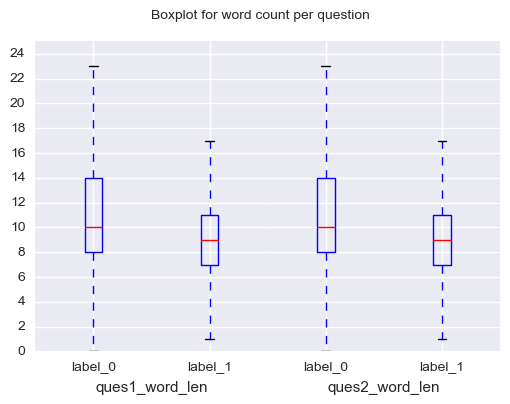

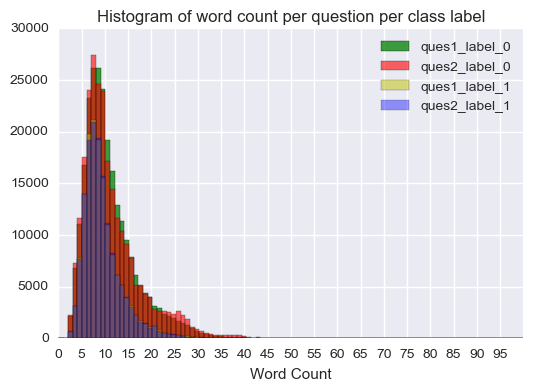

Min number of words =  0
Max number of words =  241


In [11]:
plt.close()
fig, axes = plt.subplots(ncols=2, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Boxplot for word count per question')
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))

for ax, name in zip(axes, ['ques1_word_len', 'ques2_word_len']):
    ax.boxplot([data[data['is_duplicate'] == i][name].tolist() for i in [0,1]])
    ax.set(xticklabels=['label_0', 'label_1'], xlabel=name)
plt.show()

plt.title('Histogram of word count per question per class label')
bins = np.linspace(0, 100, 100)
plt.hist(data[data['is_duplicate'] == 0]['ques1_word_len'].tolist(), bins, alpha=0.75,color='g', label='ques1_label_0')
plt.hist(data[data['is_duplicate'] == 0]['ques2_word_len'].tolist(), bins, alpha=0.6,color='r', label='ques2_label_0')
plt.hist(data[data['is_duplicate'] == 1]['ques1_word_len'].tolist(), bins, alpha=0.5, color='y',label='ques1_label_1')
plt.hist(data[data['is_duplicate'] == 1]['ques2_word_len'].tolist(), bins, alpha=0.4,color='b', label='ques2_label_1')
plt.xlabel('Word Count')
plt.xticks(np.arange(0,100,5))
plt.legend(loc='upper right')
plt.show()

print 'Min number of words = ', min(data[['ques1_word_len','ques2_word_len']].min())
print 'Max number of words = ', max(data[['ques1_word_len','ques2_word_len']].max())

### Difference in question pair words count:

The following figures shows the distribution of difference of words_count between the paired questions
I kept the negative and positive differences to see if there are some trend in the data to make some questions more lengthes than the other one.
The figures shows that the differences are equally distributed in both directions.


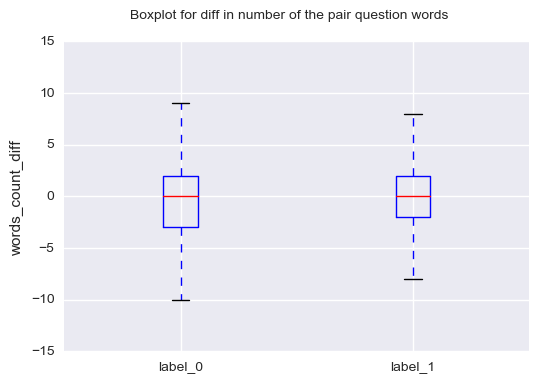

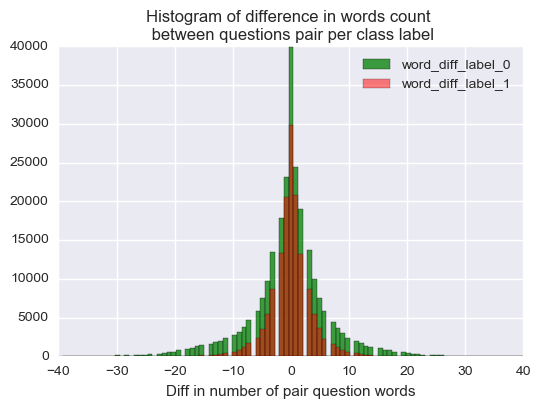

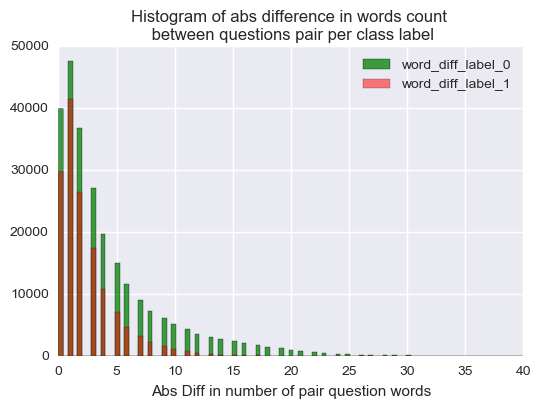

In [12]:
print('The following figures shows the distribution of difference of words_count between the paired questions')
print('I kept the negative and positive differences to see if there are some trend in the data to make some questions more lengthes than the other one.')
print('The figures shows that the differences are equally distributed in both directions.')
plt.close()
fig, ax = plt.subplots(ncols=1, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Boxplot for diff in number of the pair question words')
plt.ylim(-15,15)

ax.boxplot([data[data['is_duplicate'] == i]['words_count_diff'].tolist() for i in [0,1]])
ax.set(xticklabels=['label_0', 'label_1'], ylabel='words_count_diff')
plt.show()

plt.title('Histogram of difference in words count \n between questions pair per class label')
bins = np.linspace(-40, 40, 100)
plt.hist(data[data['is_duplicate'] == 0]['words_count_diff'].tolist(), bins, alpha=0.75,color='g', label='word_diff_label_0')
plt.hist(data[data['is_duplicate'] == 1]['words_count_diff'].tolist(), bins, alpha=0.5,color='r', label='word_diff_label_1')
plt.xlabel('Diff in number of pair question words')
plt.legend(loc='upper right')
plt.show()

plt.title('Histogram of abs difference in words count \n between questions pair per class label')
bins = np.linspace(-0, 40, 100)
plt.hist(data[data['is_duplicate'] == 0]['abs_words_count_diff'].tolist(), bins, alpha=0.75,color='g', label='word_diff_label_0')
plt.hist(data[data['is_duplicate'] == 1]['abs_words_count_diff'].tolist(), bins, alpha=0.5,color='r', label='word_diff_label_1')
plt.xlabel('Abs Diff in number of pair question words')
plt.legend(loc='upper right')
plt.show()

### Intersection between question pair:

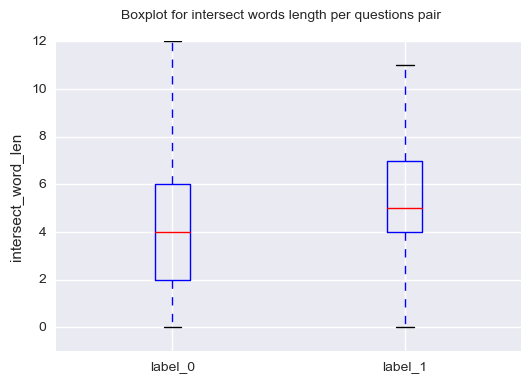

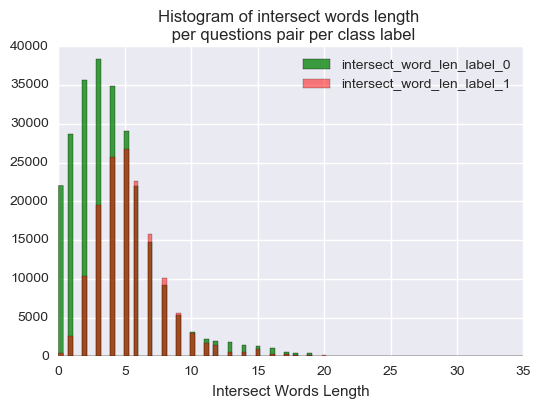

In [13]:
plt.close()
fig, ax = plt.subplots(ncols=1, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Boxplot for intersect words length per questions pair')
plt.ylim(-1,12)
ax.boxplot([data[data['is_duplicate'] == i]['intersect_word_len'].tolist() for i in [0,1]])
ax.set(xticklabels=['label_0', 'label_1'], ylabel='intersect_word_len')

plt.show()

plt.title('Histogram of intersect words length \n per questions pair per class label')
bins = np.linspace(0, 35, 100)
plt.hist(data[data['is_duplicate'] == 0]['intersect_word_len'].tolist(), bins, alpha=0.75,color='g', label='intersect_word_len_label_0')
plt.hist(data[data['is_duplicate'] == 1]['intersect_word_len'].tolist(), bins, alpha=0.5, color='r',label='intersect_word_len_label_1')
plt.xlabel('Intersect Words Length')
plt.legend(loc='upper right')
# plt.xticks(np.arange(0,20,1))
plt.show()


Percentage of data that has < 10 word intersection is 93.92% of the data
Percentage of data that has >= 10 and < 20 word intersection is 5.91% of the data
Percentage of data that has >= 20 word intersection is 0.16% of the data


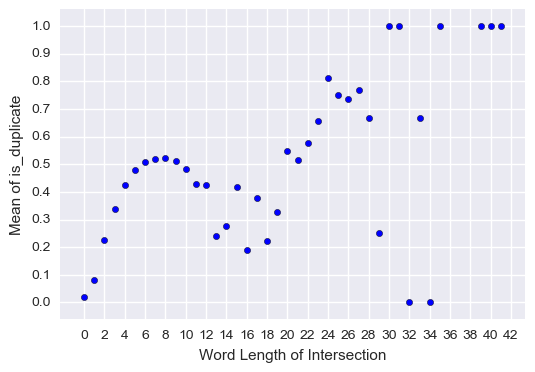

In [14]:
v = data[['intersect_word_len','is_duplicate']].groupby('intersect_word_len')[['is_duplicate']].agg([np.mean])
# plt.title('Mean of is_duplicate ')
plt.xlabel('Word Length of Intersection')
plt.ylabel('Mean of is_duplicate')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,45,2))
ax = plt.scatter(v.index.values,v['is_duplicate']['mean'].tolist())
print('Percentage of data that has < 10 word intersection is {}% of the data'.format(round(len(data[data['intersect_word_len']<10])*100.0/len(data),2)))
g_10 = data[data['intersect_word_len']>=10]
g_10_20 = g_10[g_10['intersect_word_len'] < 20]
print('Percentage of data that has >= 10 and < 20 word intersection is {}% of the data'.format(round(len(g_10_20)*100.0/len(data),2)))
print('Percentage of data that has >= 20 word intersection is {}% of the data'.format(round(len(data[data['intersect_word_len'] >= 20])*100.0/len(data),2)))

##### The above figure shows the mean of duplicate per intersection. The first part of the figure (from 0 to less than 10) make sence which with the increasing of the intersection the mean should increase. However, from (10 to 20) has different behaviour which it dcrease with the increase of intersection. So, let us focuse on this part.

Number of pairs that has between 10 and 20 common words = 23911
Number of Zero labels in this set = 61.2354146627%
Number of One labels in this set = 38.7645853373%


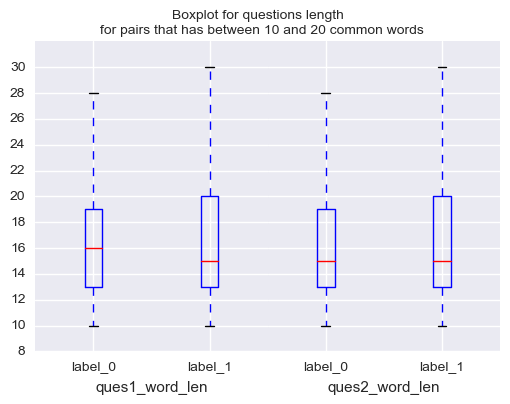

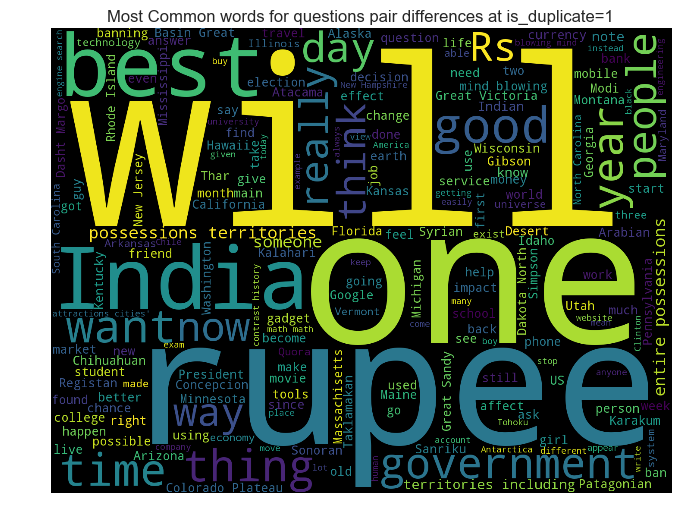

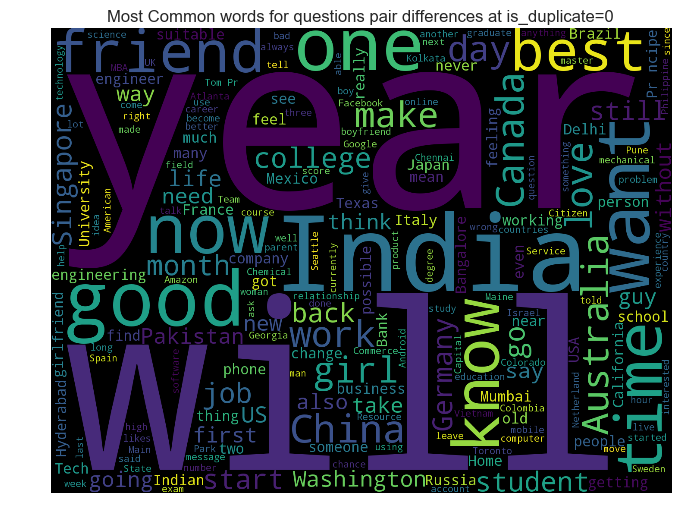

In [15]:
print('Number of pairs that has between 10 and 20 common words = {}'.format(len(g_10_20)))
print('Number of Zero labels in this set = {}%'.format(len(g_10_20[g_10_20['is_duplicate'] == 0])*100.0 / len(g_10_20)))
print('Number of One labels in this set = {}%'.format(len(g_10_20[g_10_20['is_duplicate'] == 1])*100.0 / len(g_10_20)))

plt.close()
fig, axes = plt.subplots(ncols=2, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Boxplot for questions length \n for pairs that has between 10 and 20 common words')
plt.ylim(8,32)
plt.yticks(np.arange(8,32,2))

for ax, name in zip(axes, ['ques1_word_len', 'ques2_word_len']):
    ax.boxplot([g_10_20[g_10_20['is_duplicate'] == i][name].tolist() for i in [0,1]])
    ax.set(xticklabels=['label_0', 'label_1'], xlabel=name)
plt.show()

plt.close()
diffs1 = " ".join(g_10_20[g_10_20['is_duplicate'] == 1]['unq1'].map(lambda x: " ".join(x)).tolist())
diffs2 = " ".join(g_10_20[g_10_20['is_duplicate'] == 1]['unq2'].map(lambda x: " ".join(x)).tolist())
cloud = WordCloud(width=1440, height=1080).generate(diffs1 + diffs2)
plt.figure(figsize=(8, 8))
plt.imshow(cloud)
plt.axis('off')
plt.title('Most Common words for questions pair differences at is_duplicate=1')
plt.show()

plt.close()
diffs1 = " ".join(g_10_20[g_10_20['is_duplicate'] == 0]['unq1'].map(lambda x: " ".join(x)).tolist())
diffs2 = " ".join(g_10_20[g_10_20['is_duplicate'] == 0]['unq2'].map(lambda x: " ".join(x)).tolist())
cloud = WordCloud(width=1440, height=1080).generate(diffs1 + diffs2)
plt.figure(figsize=(8, 8))
plt.imshow(cloud)
plt.axis('off')
plt.title('Most Common words for questions pair differences at is_duplicate=0')
plt.show()

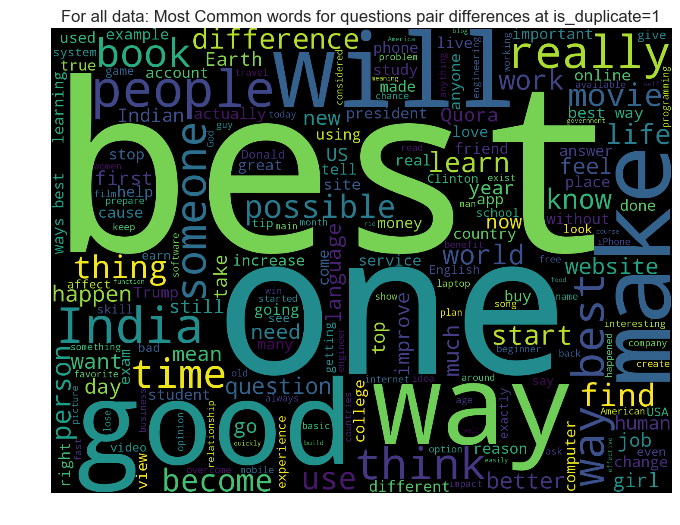

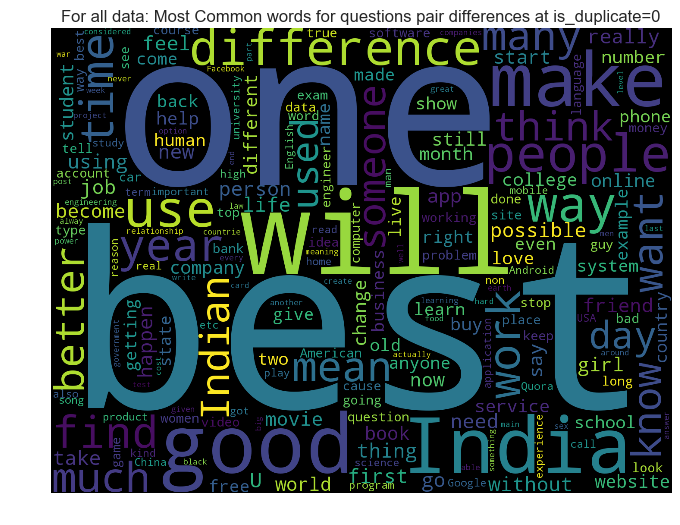

In [16]:
plt.close()
diffs1 = " ".join(data[data['is_duplicate'] == 1]['unq1'].map(lambda x: " ".join(x)).tolist())
diffs2 = " ".join(data[data['is_duplicate'] == 1]['unq2'].map(lambda x: " ".join(x)).tolist())
cloud = WordCloud(width=1440, height=1080).generate(diffs1 + diffs2)
plt.figure(figsize=(8, 8))
plt.imshow(cloud)
plt.axis('off')
plt.title('For all data: Most Common words for questions pair differences at is_duplicate=1')
plt.show()

plt.close()
diffs1 = " ".join(data[data['is_duplicate'] == 0]['unq1'].map(lambda x: " ".join(x)).tolist())
diffs2 = " ".join(data[data['is_duplicate'] == 0]['unq2'].map(lambda x: " ".join(x)).tolist())
cloud = WordCloud(width=1440, height=1080).generate(diffs1 + diffs2)
plt.figure(figsize=(8, 8))
plt.imshow(cloud)
plt.axis('off')
plt.title('For all data: Most Common words for questions pair differences at is_duplicate=0')
plt.show()

## Character Level

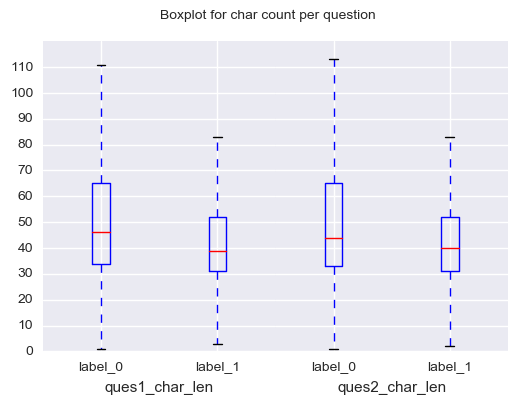

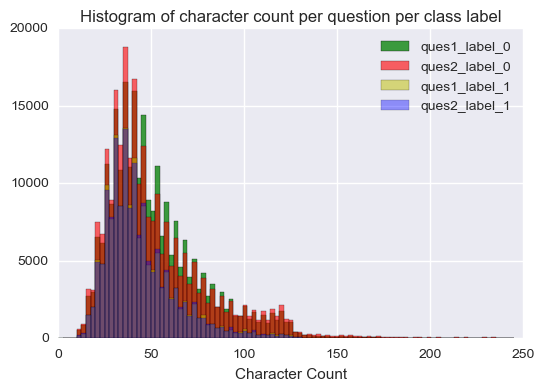

It seems that the questions with lable 0 tends to have more number of words and hence larger number of characters.


In [17]:
plt.close()
fig, axes = plt.subplots(ncols=2, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Boxplot for char count per question')
plt.ylim(0,120)
plt.yticks(np.arange(0,120,10))

for ax, name in zip(axes, ['ques1_char_len', 'ques2_char_len']):
    ax.boxplot([data[data['is_duplicate'] == i][name].tolist() for i in [0,1]])
    ax.set(xticklabels=['label_0', 'label_1'], xlabel=name)
plt.show()

plt.title('Histogram of character count per question per class label')
bins = np.linspace(0, 245, 100)
plt.hist(data[data['is_duplicate'] == 0]['ques1_char_len'].tolist(), bins, alpha=0.75,color='g', label='ques1_label_0')
plt.hist(data[data['is_duplicate'] == 0]['ques2_char_len'].tolist(), bins, alpha=0.6,color='r', label='ques2_label_0')
plt.hist(data[data['is_duplicate'] == 1]['ques1_char_len'].tolist(), bins, alpha=0.5, color='y',label='ques1_label_1')
plt.hist(data[data['is_duplicate'] == 1]['ques2_char_len'].tolist(), bins, alpha=0.4,color='b', label='ques2_label_1')
plt.xlabel('Character Count')
plt.legend(loc='upper right')
plt.show()
print('It seems that the questions with lable 0 tends to have more number of words and hence larger number of characters.')

## Simple Graph

In [31]:
graph = {}
for i in range(data.shape[0]):
    q1 = data['question1'][i]
    q2 = data['question2'][i]
    if q1 in graph:
        graph[q1].append(q2)
    else:
        graph[q1] = [q2]
        
    if q2 in graph:
        graph[q2].append(q1)
    else:
        graph[q2] = [q1]
    

In [32]:
def get_neighbor_intersect(row):
    return(len(set(graph[row['question1']]).intersection(set(graph[row['question2']]))))

data['common_neighbors'] = data.apply(get_neighbor_intersect, axis=1)

In [33]:
print 'Number of pairs that have common neighbors = {} with {}% of the data'.format(len(data[data['common_neighbors'] >= 1]), len(data[data['common_neighbors'] >= 1])*100.0/len(data))

Number of pairs that have common neighbors = 101270 with 25.0488510723% of the data


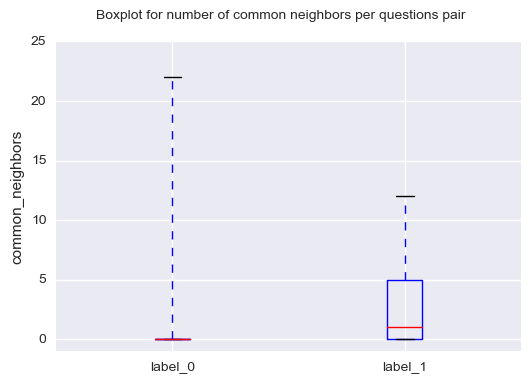

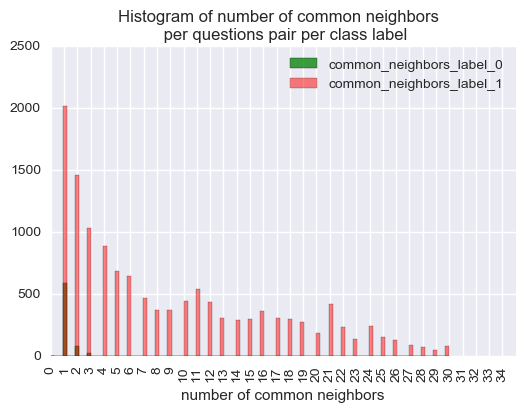

In [34]:
plt.close()
fig, ax = plt.subplots(ncols=1, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Boxplot for number of common neighbors per questions pair')
plt.ylim(-1,25)
ax.boxplot([data[data['is_duplicate'] == i]['common_neighbors'].tolist() for i in [0,1]])
ax.set(xticklabels=['label_0', 'label_1'], ylabel='common_neighbors')

plt.show()

plt.title('Histogram of number of common neighbors  \n per questions pair per class label')
bins = np.linspace(0, 30, 100)
plt.hist(data[(data['is_duplicate']==0) & (data['common_neighbors'] > 0) & (data['tags']>0)]['common_neighbors'].tolist(), bins, alpha=0.75,color='g', label='common_neighbors_label_0')
plt.hist(data[(data['is_duplicate']==1) & (data['common_neighbors'] > 0) & (data['tags']>0)]['common_neighbors'].tolist(), bins, alpha=0.5, color='r',label='common_neighbors_label_1')
plt.xlabel('number of common neighbors')
plt.legend(loc='upper right')
plt.xticks(np.arange(0,35,1))
plt.xticks(rotation='vertical')
# plt.xticks(np.arange(0,20,1))
plt.show()


In [35]:
len(data[(data['common_neighbors'] > 0) & (data['tags']>0)])*100.0/len(data)

3.51999802122239

This figure shows that if we have more than 5 common neighbors between the two questions we have a greate possiblities that the lable is 1


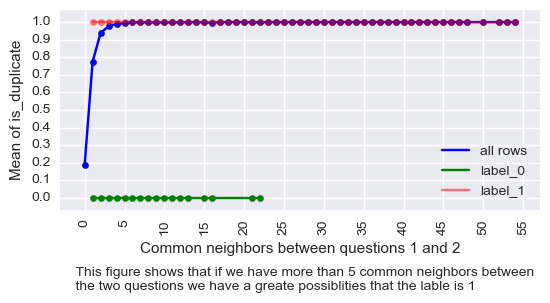

In [36]:
v = data[(data['common_neighbors'] >= 0) & (data['tags'] >= 0)][['common_neighbors','is_duplicate']].groupby('common_neighbors')[['is_duplicate']].agg([np.mean])
# v = data[['common_neighbors','is_duplicate']].groupby('common_neighbors')[['is_duplicate']].agg([np.mean])

fig = plt.figure()
ax1 = fig.add_axes((.1,.4,.8,.5))

plt.xlabel('Common neighbors between questions 1 and 2')
plt.ylabel('Mean of is_duplicate')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,70,5))
ax = ax1.plot(v.index.values,v['is_duplicate']['mean'].tolist(), color='b', label='all rows')
ax = ax1.scatter(v.index.values,v['is_duplicate']['mean'].tolist())

v = data[(data['is_duplicate']==0) & (data['common_neighbors'] > 0) & (data['tags']>=0)][['common_neighbors','is_duplicate']].groupby('common_neighbors')[['is_duplicate']].agg([np.mean])
# v = data[data['is_duplicate']==0][['common_neighbors','is_duplicate']].groupby('common_neighbors')[['is_duplicate']].agg([np.mean])
ax = ax1.plot(v.index.values,v['is_duplicate']['mean'].tolist(), color='g', label='label_0')
ax = ax1.scatter(v.index.values,v['is_duplicate']['mean'].tolist(), color='g')

v = data[(data['is_duplicate']==1) & (data['common_neighbors'] > 0) & (data['tags']>=0)][['common_neighbors','is_duplicate']].groupby('common_neighbors')[['is_duplicate']].agg([np.mean])
# v = data[data['is_duplicate']==1][['common_neighbors','is_duplicate']].groupby('common_neighbors')[['is_duplicate']].agg([np.mean])
ax = ax1.plot(v.index.values,v['is_duplicate']['mean'].tolist(), color='r', label='label_1', alpha=0.5)
ax = ax1.scatter(v.index.values,v['is_duplicate']['mean'].tolist(), color='r', alpha=0.5)
plt.xticks(rotation='vertical')

plt.legend(loc='lower right')

txt = '''
    This figure shows that if we have more than 5 common neighbors between 
    the two questions we have a greate possiblities that the lable is 1'''


# ax1.bar(x,y,.2)
fig.text(.1,.2,txt)


plt.savefig('mean_duplicate_vs_number_common_neighbors.png', bbox_inches='tight')

print('This figure shows that if we have more than 5 common neighbors between the two questions we have a greate possiblities that the lable is 1')

# Difference in same position

In [37]:
# This method is used to get the number of differences between two questions but the comparsion is poisition based.
# I compared position by position for the two questions.
def getLenWDiff(row):
    t1 = row['quest1Split']
    t2 = row['quest2Split']
    nWDiff = abs(len(t1) - len(t2))
    mlen = min(len(t1) , len(t2))
    for i in range(mlen):
        if t1[i] != t2[i]:
            nWDiff += 1
    return nWDiff


###  In the following analysis, I will focus on some incorrect labels

In [38]:
data['nWDiff'] = data[['quest1Split','quest2Split']].apply(getLenWDiff, axis=1) 


In [39]:
data_no_differences = data[(data['nWDiff'] == 0)& (data['is_duplicate'] ==0)]
print 'There are {} similar questions-pairs with label 0: '.format(str(len(data_no_differences)))
data_no_differences[['question1','question2', 'is_duplicate']].head(15)

There are 31 similar questions-pairs with label 0: 


,question1,question2,is_duplicate
3148,How do I overcome my inferiority complex ?,How do I overcome my inferiority complex?,0
23507,What is the purpose of life ?,What is the purpose of life?,0
27083,What does the Arabic text mean ?,What does the Arabic text mean?,0
35641,What to do ?,What to do?,0
66762,What should I do after completing BCA ?,What should I do after completing BCA?,0
78271,"I am 17 now, how can I ""earn"" my first house o...","I am 17 now, how can I ""earn"" my first house o...",0
115053,What are the chances I could be pregnant?,What are the chances I could be pregnant?,0
138069,Why do people say philosophy is useless and/or...,Why do people say philosophy is useless and/or...,0
143641,What is the worst excuse you've ever heard?,What is the worst excuse you have ever heard?,0
156320,"When should I use ""has been"",""have been"" and ""...","When should I use ""has been"", ""have been"" and ...",0


In [40]:
data_no_differences = data[(data['abs_words_count_diff'] == 1) & (data['nWDiff'] == 1)& (data['is_duplicate'] ==0)]
print 'There are {} questions-pairs with one word difference with label 0: '.format(str(len(data_no_differences)))
data_no_differences[['question1','question2', 'unq1', 'unq2', 'is_duplicate','tags']].head(30)

There are 708 questions-pairs with one word difference with label 0: 


,question1,question2,unq1,unq2,is_duplicate,tags
568,How do I start writing again?,How do I start writing?,[again],[],0,0
585,Can you play Asian Playstation 4 games on a Eu...,Can you play Asian Playstation 4 games on a Eu...,[],[],0,4
668,"What do you think about my short film, ""ColorS...",What do you think about my short film?,"[""ColorShift""]",[],0,0
695,Do I need to get a tetanus shot again?,Do I need to get a tetanus shot?,[again],[],0,0
1131,Who were the Aztec?,Who were the Aztec Gods?,[],[Gods],0,0
1350,How do you treat acne scars?,How do you treat acne?,[scars],[],0,0
2270,What is Visual FoxPro database?,What is Visual FoxPro?,[database],[],0,0
2314,What is oracle erp cloud?,What is oracle erp?,[cloud],[],0,0
2591,What do you mean by entrepreneur marketing?,What do you mean by entrepreneur?,[marketing],[],0,0
3224,What is happiness?,What is happiness not?,[],[not],0,0


### Distribution of difference of words in same position.

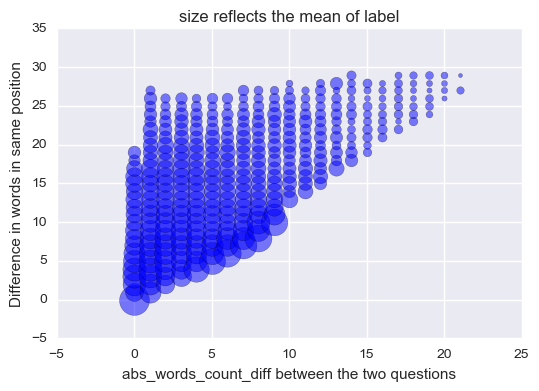

In [41]:
import cufflinks as cf
import pandas as pd

cf.set_config_file(offline=False, world_readable=True, theme='pearl')

v = data.groupby(['abs_words_count_diff','nWDiff'])[['is_duplicate']].count()
v['mean'] = data.groupby(['abs_words_count_diff','nWDiff'])[['is_duplicate']].mean()
v = v.reset_index(level=['abs_words_count_diff', 'nWDiff'])
# v.plot(kind='scatter', x=v.index.get_level_values('abs_words_count_diff'), y=v.index.get_level_values('nWDiff'), s=v['is_duplicate']['count']);

# # v[v['abs_words_count_diff'] < 50].plot(kind='scatter',x='abs_words_count_diff',y='nWDiff', s=v['is_duplicate']['count'])
# v.iplot(kind='bubble', x='abs_words_count_diff', y='nWDiff', size='is_duplicate', text='mean',
#              xTitle='GDP per Capita', yTitle='Life Expectancy',
#              filename='cufflinks/simple-bubble-chart')

v = v[(v['is_duplicate'] > 100 ) ]
fig, ax = plt.subplots(facecolor='w')
for key, row in v.iterrows():
    ax.scatter(row['abs_words_count_diff'], row['nWDiff'], s=row['mean']*500, alpha=.5)
#     ax.annotate(row['mean'], xy=(row['abs_words_count_diff'], row['nWDiff']))
plt.xlabel('abs_words_count_diff between the two questions')
plt.ylabel('Difference in words in same position')
plt.title('size reflects the mean of label')
plt.show()

In [42]:
one_w_diff_at_max = data[(data['abs_words_count_diff'] == 0) & (data['nWDiff'] == 0)& (data['nWDiff'] == 1)& (data['is_duplicate'] ==0)]
print len(one_w_diff_at_max), len(one_w_diff_at_max)*100.0/len(data)
one_w_diff_at_max.head()

0 0.0


,id,qid1,qid2,question1,question2,is_duplicate,question11,question22,quest1Split,quest2Split,...,q2_location_len,q2_organization,q2_organization_len,q2_number,q2_number_len,tags1,tags2,tags,common_neighbors,nWDiff


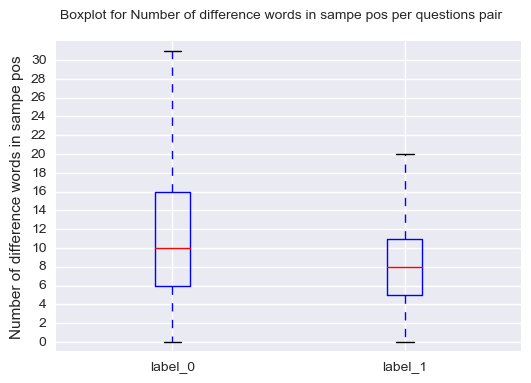

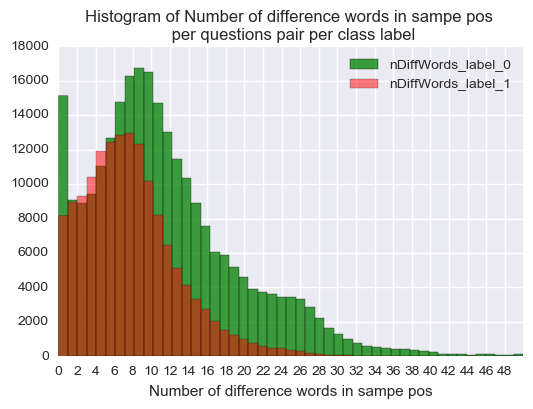

In [43]:
# .hist(bins=100, color='r', alpha=0.75)
# data[data['is_duplicate'] == 1]['nWDiff'].hist(bins=100, color='g', alpha=0.25)

plt.close()
fig, ax = plt.subplots(ncols=1, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Boxplot for Number of difference words in sampe pos per questions pair')
plt.ylim(-1,32)
plt.yticks(np.arange(0,32,2))
ax.boxplot([data[data['is_duplicate'] == i]['nWDiff'].tolist() for i in [0,1]])
ax.set(xticklabels=['label_0', 'label_1'], ylabel='Number of difference words in sampe pos')

plt.show()

plt.title('Histogram of Number of difference words in sampe pos \n per questions pair per class label')
bins = np.linspace(0, 50, 50)
plt.hist(data[data['is_duplicate'] == 0]['nWDiff'].tolist(), bins, alpha=0.75,color='g', label='nDiffWords_label_0')
plt.hist(data[data['is_duplicate'] == 1]['nWDiff'].tolist(), bins, alpha=0.5, color='r',label='nDiffWords_label_1')
plt.xlabel('Number of difference words in sampe pos')
plt.legend(loc='upper right')
plt.xticks(np.arange(0,50,2))
plt.show()

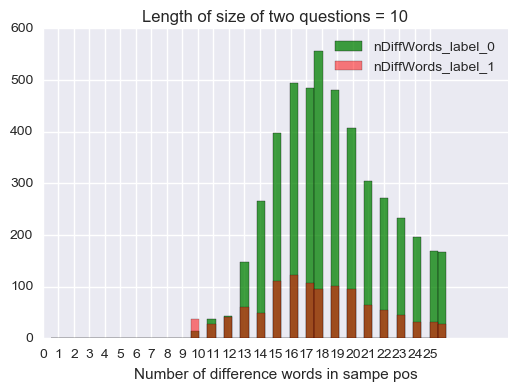

In [44]:
data_same_length = data[abs(data['ques1_word_len'] - data['ques2_word_len']) == 10 ]
# data_differences = data_same_length[data_same_length['nWDiff'] == 11 ]
# len(data_differences), len(data_same_length), len(data_with_label_0), len(data_differences)*100.0/ len(data_with_label_0)
bins = np.linspace(0, 26, 50)
plt.hist(data_same_length[data_same_length['is_duplicate'] == 0]['nWDiff'].tolist(), bins, alpha=0.75,color='g', label='nDiffWords_label_0')
plt.hist(data_same_length[data_same_length['is_duplicate'] == 1]['nWDiff'].tolist(), bins, alpha=0.5, color='r',label='nDiffWords_label_1')
plt.xlabel('Number of difference words in sampe pos')
plt.legend(loc='upper right')
plt.title('Length of size of two questions = 10')
plt.xticks(np.arange(0,26,1))
plt.show()

In [45]:
data_same_length = pd.DataFrame()
data_same_length['diff_len'] = abs(data['ques1_word_len'] - data['ques2_word_len'])
data_same_length['nWDiff'] = data['nWDiff']
data_same_length['is_duplicate'] = data['is_duplicate']

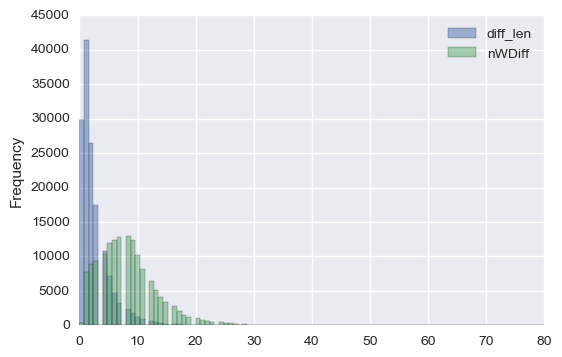

In [46]:
ddd = data_same_length[(data_same_length['diff_len']<60)&(data_same_length['is_duplicate'] == 1)]
# ddd[['diff_len','nWDiff']].plot(kind='scatter', x='diff_len', y='nWDiff')
ddd[['diff_len','nWDiff']].plot(kind='hist',bins=100, alpha=0.5)

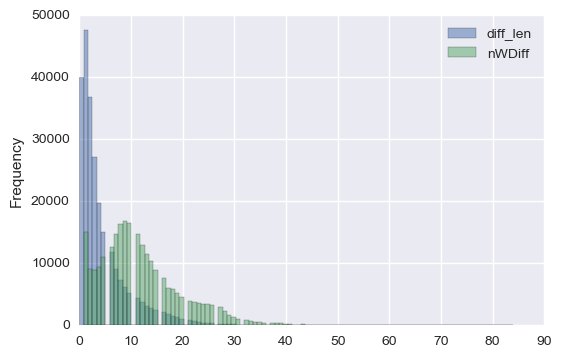

In [47]:
ddd = data_same_length[(data_same_length['diff_len']<60)&(data_same_length['is_duplicate'] == 0)]
# ddd[['diff_len','nWDiff']].plot(kind='scatter', x='diff_len', y='nWDiff')
ddd[['diff_len','nWDiff']].plot(kind='hist',bins=100, alpha=0.5)